# Representation Scenarios and Modeling Comparisons

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("C:/Users/smrit/OneDrive/Desktop/DTSC 3602/Project/Datasets/Crime Data/Crime_Data_from_2020_to_Present.csv", low_memory=False)
cols = ['AREA NAME', 'Crm Cd Desc', 'Vict Sex', 'Vict Age', 'LAT', 'LON']
df = df[cols].dropna()
df = df[df['Vict Sex'].isin(['M', 'F'])]
df = df.sample(10000, random_state=42)

y = df['Vict Sex']

In [99]:
# Baseline Representation
X_base = df.drop(columns=['Vict Sex'])
X_base = X_base.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)) if col.dtype == 'object' else col)
X_train_b, X_test_b, y_train, y_test = train_test_split(X_base, y, test_size=0.3, random_state=42)

In [100]:
# Improved Representation
X_imp = df.copy()
bins = [0, 18, 30, 50, 70, 120]
labels = ['Under18', '18-30', '30-50', '50-70', '70+']
X_imp['AgeGroup'] = pd.cut(X_imp['Vict Age'], bins=bins, labels=labels, right=False)
X_imp = X_imp.drop(columns=['Vict Age'])
X_imp = pd.get_dummies(X_imp, drop_first=True)
scaler = StandardScaler()
num_cols = X_imp.select_dtypes(include=['float64', 'int64']).columns
X_imp[num_cols] = scaler.fit_transform(X_imp[num_cols])
X_train_i, X_test_i, _, _ = train_test_split(X_imp, y, test_size=0.3, random_state=42)

In [101]:
def evaluate_models(X_train, X_test, y_train, y_test, label):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label='M')
        rec = recall_score(y_test, y_pred, pos_label='M')
        f1 = f1_score(y_test, y_pred, pos_label='M')
        male_acc = accuracy_score(y_test[y_test=='M'], y_pred[y_test=='M'])
        female_acc = accuracy_score(y_test[y_test=='F'], y_pred[y_test=='F'])
        fairness_gap = abs(male_acc - female_acc)
        results.append({
            'Scenario': label, 'Model': name,
            'Accuracy': round(acc,3), 'Precision': round(prec,3),
            'Recall': round(rec,3), 'F1': round(f1,3), 'Fairness_Gap': round(fairness_gap,3)
        })
    return pd.DataFrame(results)
baseline_results = evaluate_models(X_train_b, X_test_b, y_train, y_test, 'Baseline')
improved_results = evaluate_models(X_train_i, X_test_i, y_train, y_test, 'Improved')
results = pd.concat([baseline_results, improved_results])
print(results)

   Scenario                Model  Accuracy  Precision  Recall     F1  \
0  Baseline  Logistic Regression     0.534      0.546   0.720  0.622   
1  Baseline        Decision Tree     0.576      0.603   0.590  0.596   
2  Baseline        Random Forest     0.587      0.609   0.618  0.613   
0  Improved  Logistic Regression     1.000      1.000   1.000  1.000   
1  Improved        Decision Tree     1.000      1.000   1.000  1.000   
2  Improved        Random Forest     1.000      1.000   1.000  1.000   

   Fairness_Gap  
0         0.397  
1         0.031  
2         0.067  
0         0.000  
1         0.000  
2         0.000  


In [102]:
# Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_i, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train_i.columns).sort_values(ascending=False)
print('Top 5 Important Features (Improved Representation):')
print(importances.head(5))

Top 5 Important Features (Improved Representation):
Vict Sex_M                                                    0.871342
LAT                                                           0.026461
LON                                                           0.024098
Crm Cd Desc_INTIMATE PARTNER - SIMPLE ASSAULT                 0.009216
Crm Cd Desc_ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    0.005573
dtype: float64


# Data Integration and Cleaning Notebook 

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import seaborn as sns

crime_df = pd.read_csv(r"C:\Users\smrit\OneDrive\Desktop\DTSC 3602\Project\Datasets\Crime Data\Crime_Data_from_2020_to_Present.csv")
income_df = pd.read_csv(r"C:\Users\smrit\OneDrive\Desktop\DTSC 3602\Project\Datasets\Household Income\Income_data.csv")

print("crime dataset shape:", crime_df.shape)
print("income dataset shape:", income_df.shape)

display(crime_df.head())
display(income_df.head())

print("crime columns: ", crime_df.columns.tolist())
print("income columns: ", income_df.columns.tolist())

crime dataset shape: (1004991, 28)
income dataset shape: (1613, 37)


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


,GEO_ID,NAME,B19001_001E,B19001_001M,B19001_002E,B19001_002M,B19001_003E,B19001_003M,B19001_004E,B19001_004M,...,B19001_013M,B19001_014E,B19001_014M,B19001_015E,B19001_015M,B19001_016E,B19001_016M,B19001_017E,B19001_017M,Unnamed: 36
0,Geography,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,"Estimate!!Total:!!Less than $10,000","Margin of Error!!Total:!!Less than $10,000","Estimate!!Total:!!$10,000 to $14,999","Margin of Error!!Total:!!$10,000 to $14,999","Estimate!!Total:!!$15,000 to $19,999","Margin of Error!!Total:!!$15,000 to $19,999",...,"Margin of Error!!Total:!!$75,000 to $99,999","Estimate!!Total:!!$100,000 to $124,999","Margin of Error!!Total:!!$100,000 to $124,999","Estimate!!Total:!!$125,000 to $149,999","Margin of Error!!Total:!!$125,000 to $149,999","Estimate!!Total:!!$150,000 to $199,999","Margin of Error!!Total:!!$150,000 to $199,999","Estimate!!Total:!!$200,000 or more","Margin of Error!!Total:!!$200,000 or more",NaN
1,0400000US06,California,13103114,18542,614887,6699,507398,5286,435382,5251,...,9649,1295090,9124,940024,8511,1227224,8960,1739375,11874,NaN
2,1600000US0600135,"Acalanes Ridge CDP, California",348,105,10,18,0,13,0,13,...,13,0,13,19,32,38,45,124,68,NaN
3,1600000US0600156,"Acampo CDP, California",131,139,0,13,0,13,0,13,...,13,0,13,50,78,0,13,0,13,NaN
4,1600000US0600212,"Acton CDP, California",2584,195,113,74,110,81,53,59,...,108,297,94,215,90,291,108,463,117,NaN


crime columns:  ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']
income columns:  ['GEO_ID', 'NAME', 'B19001_001E', 'B19001_001M', 'B19001_002E', 'B19001_002M', 'B19001_003E', 'B19001_003M', 'B19001_004E', 'B19001_004M', 'B19001_005E', 'B19001_005M', 'B19001_006E', 'B19001_006M', 'B19001_007E', 'B19001_007M', 'B19001_008E', 'B19001_008M', 'B19001_009E', 'B19001_009M', 'B19001_010E', 'B19001_010M', 'B19001_011E', 'B19001_011M', 'B19001_012E', 'B19001_012M', 'B19001_013E', 'B19001_013M', 'B19001_014E', 'B19001_014M', 'B19001_015E', 'B19001_015M', 'B19001_016E', 'B19001_016M', 'B19001_017E', 'B19001_017M', 'Unnamed: 36']


The datasets were loaded and the columns were printed to visualize what was inside of the csv files.

Crime dataset included original target variables and features like Crime Cd Desc, Date, and Area Name. Income dataset included features by city or region like median income and ownership (rented vs owned)

In [104]:
income_df = income_df.drop(columns=['Unnamed: 36'], errors='ignore')
income_df = income_df.rename(columns={'NAME': 'City'})

for col in income_df.columns:
    if col.startswith("B19001_"):
        income_df[col] = pd.to_numeric(income_df[col], errors='coerce')

income_brackets = {
    "B19001_002E": 2500, "B19001_003E": 7500, "B19001_004E": 12500,
    "B19001_005E": 17500, "B19001_006E": 22500, "B19001_007E": 27500,
    "B19001_008E": 32500, "B19001_009E": 37500, "B19001_010E": 42500,
    "B19001_011E": 47500, "B19001_012E": 55000, "B19001_013E": 67500,
    "B19001_014E": 87500, "B19001_015E": 112500, "B19001_016E": 137500,
    "B19001_017E": 200000
}

for col, midpoint in income_brackets.items():
    if col in income_df.columns:
        income_df[col + '_weighted'] = income_df[col] * midpoint

income_df['total_households'] = income_df['B19001_001E']
weighted_cols = [c for c in income_df.columns if c.endswith('_weighted')]
income_df['estimated_income_total'] = income_df[weighted_cols].sum(axis=1)
income_df['median_income_est'] = income_df['estimated_income_total'] / income_df['total_households']

income_final = income_df[['GEO_ID', 'City', 'median_income_est']].dropna()

display(income_final.head())

,GEO_ID,City,median_income_est
1,0400000US06,California,79406.359435
2,1600000US0600135,"Acalanes Ridge CDP, California",110402.298851
3,1600000US0600156,"Acampo CDP, California",54370.229008
4,1600000US0600212,"Acton CDP, California",90808.823529
5,1600000US0600296,"Adelanto city, California",49413.452857


In this step, we multiply midpoints of the brackets and divide it by the number of total households to get the average income for each city in California.

In [105]:
API_KEY = "84c860677c99f5cadf46c69bd917971eecc4cbc8"
print(crime_df[['LAT', 'LON']].head())
if (crime_df['LON'] > 0).any():
    crime_df['LON'] = crime_df['LON'] * -1
    print("✅ Longitude values corrected (multiplied by -1).")

crime_df = crime_df.dropna(subset=['LAT', 'LON'])

       LAT       LON
0  34.2124 -118.4092
1  34.1993 -118.4203
2  34.1847 -118.4509
3  34.0339 -118.3747
4  33.9813 -118.4350


In [106]:
def get_geoid(lat, lon):
    """
    Uses the U.S. Census Geocoder API to fetch the GEO_ID for a given coordinate.
    Compatible with 2025 settings (Public_AR_Current + Current_Current).
    """
    try:
        base_url = "https://geocoding.geo.census.gov/geocoder/geographies/coordinates"
        params = {
            "x": lon,
            "y": lat,
            "benchmark": "Public_AR_Current",
            "vintage": "Current_Current",
            "format": "json"
        }
        r = requests.get(base_url, params=params)
        data = r.json()

        geographies = data.get("result", {})
        if "Places" in geographies and geographies["Places"]:
            place_id = geographies["Places"][0]["GEOID"]
            return f"1600000US{place_id}" 
        elif "Census Tracts" in geographies and geographies["Census Tracts"]:
            tract_id = geographies["Census Tracts"][0]["GEOID"]
            return f"1400000US{tract_id}"
        else:
            return None
    except Exception as e:
        return None

lat, lon = crime_df.loc[0, 'LAT'], crime_df.loc[0, 'LON']
print("Testing one coordinate through API:")
print(get_geoid(lat, lon))

Testing one coordinate through API:
None


The variable that has been chosen to link the datasets are AREA NAME in the crime dataset and NAME in the income dataset

In [107]:
print("Example LAPD areas:", crime_df['AREA NAME'].unique()[:10])
print("Example income cities:", income_final['City'].unique()[:10])

crime_clean = crime_df.copy()
income_clean = income_final.copy()
crime_clean['AREA NAME'] = crime_clean['AREA NAME'].str.strip().str.lower()
income_clean['City'] = income_clean['City'].astype(str).str.strip().str.lower()

lapd_to_city = {
    "n hollywood": "los angeles city, california",
    "van nuys": "los angeles city, california",
    "wilshire": "los angeles city, california",
    "pacific": "santa monica city, california",
    "hollenbeck": "los angeles city, california",
    "central": "los angeles city, california",
    "southwest": "los angeles city, california",
    "harbor": "san pedro city, california",
    "hollywood": "los angeles city, california",
    "west la": "los angeles city, california",
    "northeast": "los angeles city, california",
    "77th street": "los angeles city, california",
    "newton": "los angeles city, california",
    "foothill": "los angeles city, california",
    "mission": "los angeles city, california",
    "topanga": "los angeles city, california",
    "olympic": "los angeles city, california",
    "southeast": "los angeles city, california",
    "devonshire": "los angeles city, california",
    "rampart": "los angeles city, california",
    "west valley": "los angeles city, california"
}

crime_clean['matched_city'] = crime_clean['AREA NAME'].map(lapd_to_city)

merged_df = pd.merge(
    crime_clean,
    income_clean[['City', 'median_income_est']],
    left_on='matched_city',
    right_on='City',
    how='left'
)
print(merged_df.shape)
display(merged_df[['AREA NAME', 'matched_city', 'median_income_est']].head(10))

Example LAPD areas: ['N Hollywood' 'Van Nuys' 'Wilshire' 'Pacific' 'Hollenbeck' 'Southwest'
 'Northeast' 'Devonshire' 'Topanga' 'Hollywood']
Example income cities: ['California' 'Acalanes Ridge CDP, California' 'Acampo CDP, California'
 'Acton CDP, California' 'Adelanto city, California'
 'Adin CDP, California' 'Agoura Hills city, California'
 'Agua Dulce CDP, California' 'Aguanga CDP, California'
 'Ahwahnee CDP, California']
(1004991, 31)


,AREA NAME,matched_city,median_income_est
0,n hollywood,"los angeles city, california",70336.588303
1,n hollywood,"los angeles city, california",70336.588303
2,van nuys,"los angeles city, california",70336.588303
3,wilshire,"los angeles city, california",70336.588303
4,pacific,"santa monica city, california",92706.865619
5,hollenbeck,"los angeles city, california",70336.588303
6,southwest,"los angeles city, california",70336.588303
7,northeast,"los angeles city, california",70336.588303
8,devonshire,"los angeles city, california",70336.588303
9,topanga,"los angeles city, california",70336.588303


In [108]:
if 'crime_count' in merged_df.columns:
    merged_df = merged_df.drop(columns=['crime_count'], errors='ignore')
if 'avg_area_income' in merged_df.columns:
    merged_df = merged_df.drop(columns=['avg_area_income'], errors='ignore')
if 'income_to_crime_ratio' in merged_df.columns:
    merged_df = merged_df.drop(columns=['income_to_crime_ratio'], errors='ignore')

area_crime_counts = merged_df.groupby('AREA NAME').size().reset_index(name='crime_count')
merged_df = merged_df.merge(area_crime_counts, on='AREA NAME', how='left', validate='m:1')

area_income = merged_df.groupby('AREA NAME', as_index=False)['median_income_est'].mean()
area_income = area_income.rename(columns={'median_income_est': 'avg_area_income'})
merged_df = merged_df.merge(area_income, on='AREA NAME', how='left', validate='m:1')


median_income_cutoff = merged_df['avg_area_income'].median()
merged_df['income_bracket'] = np.where(
    merged_df['avg_area_income'] < median_income_cutoff,
    'Low Income Area', 'High Income Area'
)

print(merged_df.shape)
display(merged_df[['AREA NAME', 'avg_area_income', 'crime_count','income_bracket']].head(10))

(1004991, 34)


,AREA NAME,avg_area_income,crime_count,income_bracket
0,n hollywood,70336.588303,51107,High Income Area
1,n hollywood,70336.588303,51107,High Income Area
2,van nuys,70336.588303,42883,High Income Area
3,wilshire,70336.588303,48239,High Income Area
4,pacific,92706.865619,59514,High Income Area
5,hollenbeck,70336.588303,37085,High Income Area
6,southwest,70336.588303,57441,High Income Area
7,northeast,70336.588303,42963,High Income Area
8,devonshire,70336.588303,41756,High Income Area
9,topanga,70336.588303,41374,High Income Area


The datasets have been merged by AREA NAME.

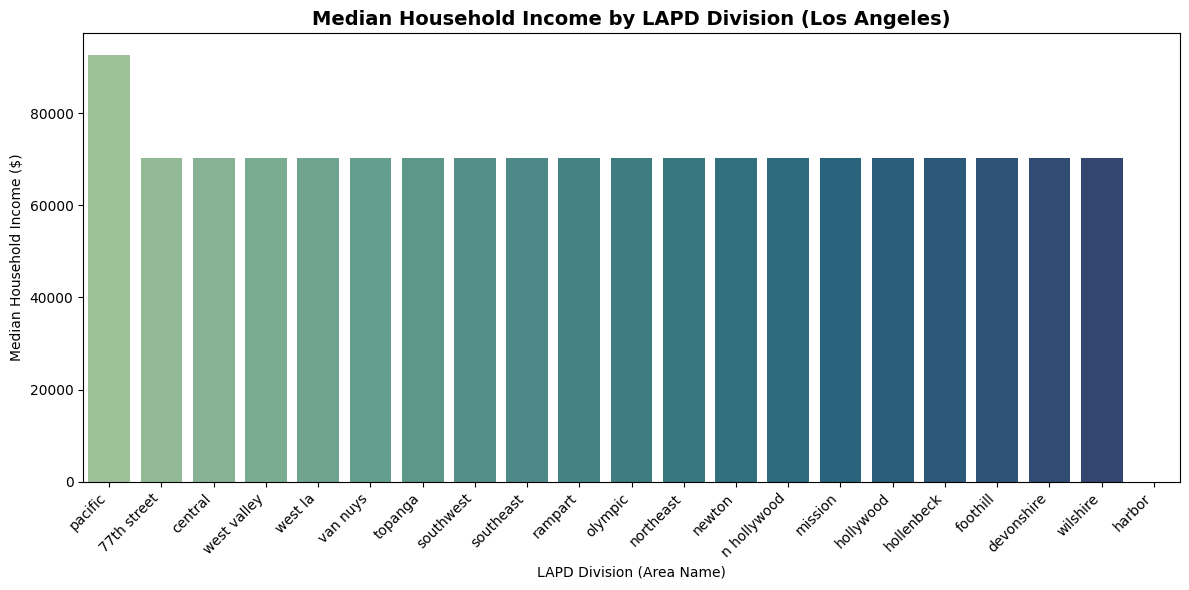

,AREA NAME,median_income_est
12,pacific,92706.865619
0,77th street,70336.588303
1,central,70336.588303
19,west valley,70336.588303
18,west la,70336.588303
17,van nuys,70336.588303
16,topanga,70336.588303
15,southwest,70336.588303
14,southeast,70336.588303
13,rampart,70336.588303


In [109]:
income_summary = (
    merged_df.groupby('AREA NAME')['median_income_est']
    .median()
    .reset_index()
    .sort_values('median_income_est', ascending=False)
)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=income_summary,
    x='AREA NAME',
    y='median_income_est',
    palette='crest'
)

plt.title("Median Household Income by LAPD Division (Los Angeles)", fontsize=14, weight='bold')
plt.xlabel("LAPD Division (Area Name)")
plt.ylabel("Median Household Income ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

display(income_summary)



In [110]:
merged_df.to_csv(r"C:\Users\smrit\OneDrive\Desktop\DTSC 3602\Project\Datasets\Merged_Final.csv", index=False)

Final merged dataset saved in the project folder.

# Modeling and Comparing Contextual Features

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.read_csv(r"C:\Users\smrit\OneDrive\Desktop\DTSC 3602\Project\Datasets\Merged_Final.csv")
merged_df = merged_df.dropna(subset=[
    'Vict Age', 'Vict Sex', 'Vict Descent', 'AREA NAME',
    'avg_area_income', 'crime_count', 'income_bracket', 'Crm Cd Desc'
])

print("shape:", merged_df.shape)
print("columns:", merged_df.columns.tolist())
merged_df.head()

shape: (826276, 34)
columns: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON', 'matched_city', 'City', 'median_income_est', 'crime_count', 'avg_area_income', 'income_bracket']


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,LOCATION,Cross Street,LAT,LON,matched_city,City,median_income_est,crime_count,avg_area_income,income_bracket
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,n hollywood,1502,2,354,THEFT OF IDENTITY,...,7800 BEEMAN AV,NaN,34.2124,-118.4092,"los angeles city, california","los angeles city, california",70336.588303,51107,70336.588303,High Income Area
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,n hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,ATOLL AV,N GAULT,34.1993,-118.4203,"los angeles city, california","los angeles city, california",70336.588303,51107,70336.588303,High Income Area
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,van nuys,933,2,354,THEFT OF IDENTITY,...,14600 SYLVAN ST,NaN,34.1847,-118.4509,"los angeles city, california","los angeles city, california",70336.588303,42883,70336.588303,High Income Area
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,6000 COMEY AV,NaN,34.0339,-118.3747,"los angeles city, california","los angeles city, california",70336.588303,48239,70336.588303,High Income Area
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,4700 LA VILLA MARINA,NaN,33.9813,-118.4350,"santa monica city, california","santa monica city, california",92706.865619,59514,92706.865619,High Income Area


In [112]:
target = 'Crm Cd Desc'
base_features = ['Vict Age', 'Vict Sex', 'Vict Descent', 'AREA NAME']
context_features = base_features + ['avg_area_income', 'crime_count','income_bracket']

merged_df = merged_df.dropna(subset=[target])

In [113]:
X_base = merged_df[base_features]
X_context = merged_df[context_features]
y = merged_df[target]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y, test_size=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_context, y, test_size=0.3, random_state=42)

In [114]:
num_features_b = ['Vict Age']
cat_features_b = ['Vict Sex', 'Vict Descent', 'AREA NAME']

num_features_c = ['Vict Age', 'income_bracket']
cat_features_c = ['Vict Sex', 'Vict Descent', 'AREA NAME']


In [115]:
num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_base = ColumnTransformer([
    ('num', num_pipeline, ['Vict Age']),
    ('cat', cat_pipeline, ['Vict Sex', 'Vict Descent', 'AREA NAME'])
])

preprocessor_context = ColumnTransformer([
    ('num', num_pipeline, ['Vict Age', 'avg_area_income', 'crime_count']),
    ('cat', cat_pipeline, ['Vict Sex', 'Vict Descent', 'AREA NAME', 'income_bracket'])
])

base_model = Pipeline([
    ('preprocessor', preprocessor_base),
    ('classifier', RandomForestClassifier(
        n_estimators=60,
        max_depth=12,
        min_samples_split=4,
        random_state=42,
        n_jobs=-1
    ))
])

context_model = Pipeline([
    ('preprocessor', preprocessor_context),
    ('classifier', RandomForestClassifier(
        n_estimators=60,
        max_depth=12,
        min_samples_split=4,
        random_state=42,
        n_jobs=-1
    ))
])

In [116]:
base_model.fit(X_train_b, y_train_b)
context_model.fit(X_train_c, y_train_c)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


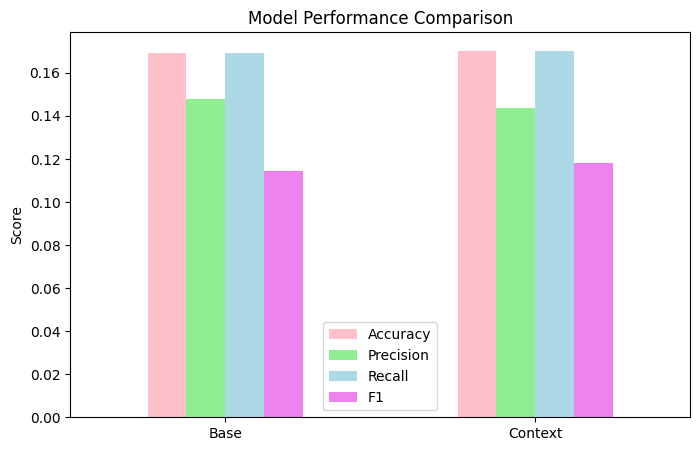

,Accuracy,Precision,Recall,F1
Base,0.169221,0.147928,0.169221,0.114626
Context,0.170338,0.143578,0.170338,0.118316


In [117]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, preds, average='weighted', zero_division=0),
        'F1': f1_score(y_test, preds, average='weighted', zero_division=0)
    }

base_metrics = evaluate(base_model, X_test_b, y_test_b)
context_metrics = evaluate(context_model, X_test_c, y_test_c)

compare_df = pd.DataFrame([base_metrics, context_metrics], index=['Base', 'Context'])
compare_df.plot(kind='bar', figsize=(8,5), color=['pink', 'lightgreen', 'lightblue', 'violet'])
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()
compare_df